## Mumbai House Price Prediction using KNNs

In [ ]:
import hashlib 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Generating a personalized random seed
username = "prit.kanadiya"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
print(seed)

1379217023


In [3]:
# Obtain the modified csv 
# Refer assets/scripts/house-price-dataset.py for preprocessing steps
data = "../assets/data/modified_mumbai_house_prices.csv"
house_price = pd.read_csv(data)
house_price = house_price.sample(frac=1, random_state=seed).reset_index(drop=True)    # Randomly shuffle data

In [4]:
# printing the info for dataset
print(house_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bhk        76038 non-null  int64  
 1   type       76038 non-null  float64
 2   area       76038 non-null  int64  
 3   price      76038 non-null  float64
 4   status     76038 non-null  int64  
 5   age        76038 non-null  float64
 6   latitude   76038 non-null  float64
 7   longitude  76038 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 4.6 MB
None


In [5]:
house_price.head()
print(house_price.shape)

(76038, 8)


In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(house_price['price'])
plt.title('Boxplot of House Prices')
plt.ylabel('Price')
plt.show()

In [ ]:
class KNN():
    def __init__(self, k: int, metric: str = "euclidean", weights: str = "uniform"):
        self.k = k
        self.weights = weights
        self.metric = metric    # [euclidean, manhattan, edit]
    
    def calculate_distance(self, p, q):
        if (self.metric == "euclidean"):
            dist = np.sqrt(np.sum((p - q) ** 2))
        elif (self.metric == "manhattan"):
            dist = np.sum(abs(p - q))
        # elif (self.metric == "edit"):
        #     dist = distance(p, q)
        
        return dist
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def is_vowel(self, x):
        if (x == "a" or x == "e" or x == "i" or x == "o" or x == "u"):
            return True
    
    def predict(self, X, ):
        X_train = self.X_train.copy()
        y_train = self.y_train.copy()

        preds = []
        for i in tqdm(range(len(X))):
            dist = []
            for j in range(len(self.X_train)):
                dist.append(self.calculate_distance(X[i], X_train[j]))

            dist = np.array(dist)
            idx = np.argsort(dist)
            dist = dist[idx]
            X_train = X_train[idx] 
            y_train = y_train[idx]   

            neighbors = X_train[:self.k]
            labels = y_train[:self.k]
            dist = dist[:self.k]

            if (self.metric == "edit"):
                for k in range(len(neighbors)):
                    if (self.calculate_distance(neighbors[k], X[i]) == 1):
                        if (len(neighbors[k]) > len(X[i]) and self.is_vowel(neighbors[k][-1])):
                            labels[k] = 1 - labels[k]
                        elif (len(neighbors[k]) < len(X[i]) and self.is_vowel(X[i][-1])):
                            labels[k] = 1 - labels[k]

            if (self.weights == "uniform"):
                vote = np.mean(labels)    
                pred = vote

            elif (self.weights == "distance"):
                eps = 1e-6    # For cases when the test is present in train data
                weights = 1 / (dist + eps)
                vote = np.sum(weights * labels) / np.sum(weights)
                pred = vote
            
            preds.append(pred)
            
        return preds
    
    def get_mse(self, X, y):
        preds = self.predict(X)
        mse = np.mean((preds - y)**2)
        return mse

In [7]:
# Separating X and y and splitting dataset into train, validation and test
X = house_price.drop(columns=["price"]).to_numpy()
y = house_price["price"].to_numpy()

val_split = 0.05
test_split = 0.05

X_train = X[:int(len(y)*(1-test_split-val_split))]
X_val = X[int(len(y)*(1-test_split-val_split)): int(len(y)*(1-val_split))]
X_test = X[int(len(y)*(1-val_split)):]
y_train = y[:int(len(y)*(1-test_split-val_split))]
y_val = y[int(len(y)*(1-test_split-val_split)): int(len(y)*(1-val_split))]
y_test = y[int(len(y)*(1-val_split)):]

print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")


Training data: (68434, 7), (68434,)
Validation data: (3802, 7), (3802,)
Testing data: (3802, 7), (3802,)


In [8]:
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Normalizing the data
X_train = (X_train - X_mean)/X_std
X_val = (X_val - X_mean) / X_std
X_test = (X_test - X_mean)/X_std

print(X_train[:1])

[[-0.01572488  0.03055003  0.06138012  0.8303733  -1.36061645 -0.52374883
   1.08818964]]


In [9]:
knn = KNN(k=3, metric="euclidean", weights="uniform")
knn.fit(X_train, y_train)
# preds = knn.predict(X_val)

In [10]:
mse = knn.get_mse(X_val, y_val)
print(f"MSE: {mse}")

100%|██████████| 3802/3802 [12:05<00:00,  5.24it/s]

MSE: 1.064132212981764


100%|██████████| 3802/3802 [11:56<00:00,  5.31it/s]


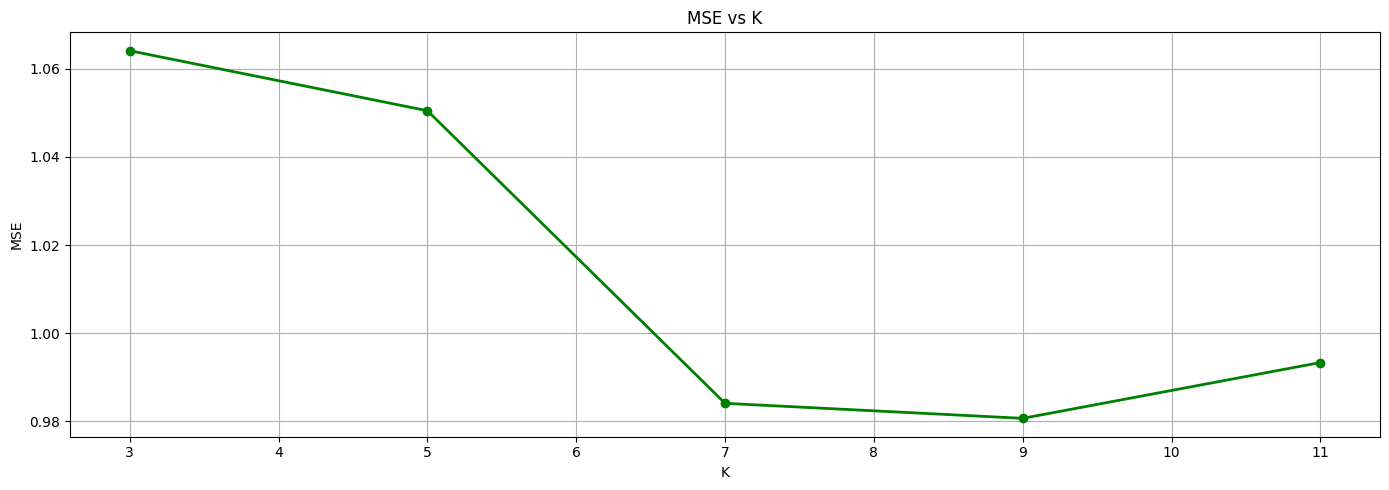

In [11]:
# Trying several values of K over validation set
mse_list = []
K_list = [i for i in range(3, 13, 2)]   
for K in K_list:
    knn = KNN(k=K, metric="euclidean", weights="uniform")
    knn.fit(X_train, y_train)
    mse = knn.get_mse(X_val, y_val)
    mse_list.append(mse)

plt.figure(figsize=(14, 5))
plt.plot(K_list, mse_list, color='green', marker='o', linewidth=2)
plt.xlabel("K")
plt.ylabel("MSE")
plt.title("MSE vs K")
plt.grid(True)
plt.tight_layout()
plt.show()

The best value of MSE is obtained at `K = 9` which is around `0.98`. The RMSE comes to be around `0.99 Cr`, which is a very high error for house prices.

In [12]:
knn = KNN(k=9, metric="euclidean", weights="distance")
knn.fit(X_train, y_train)
# preds = knn.predict(X_val)

In [13]:
mse = knn.get_mse(X_val, y_val)
print(f"MSE: {mse}")

100%|██████████| 3802/3802 [11:55<00:00,  5.31it/s]

MSE: 0.8984633183348364


100%|██████████| 3802/3802 [12:00<00:00,  5.27it/s]


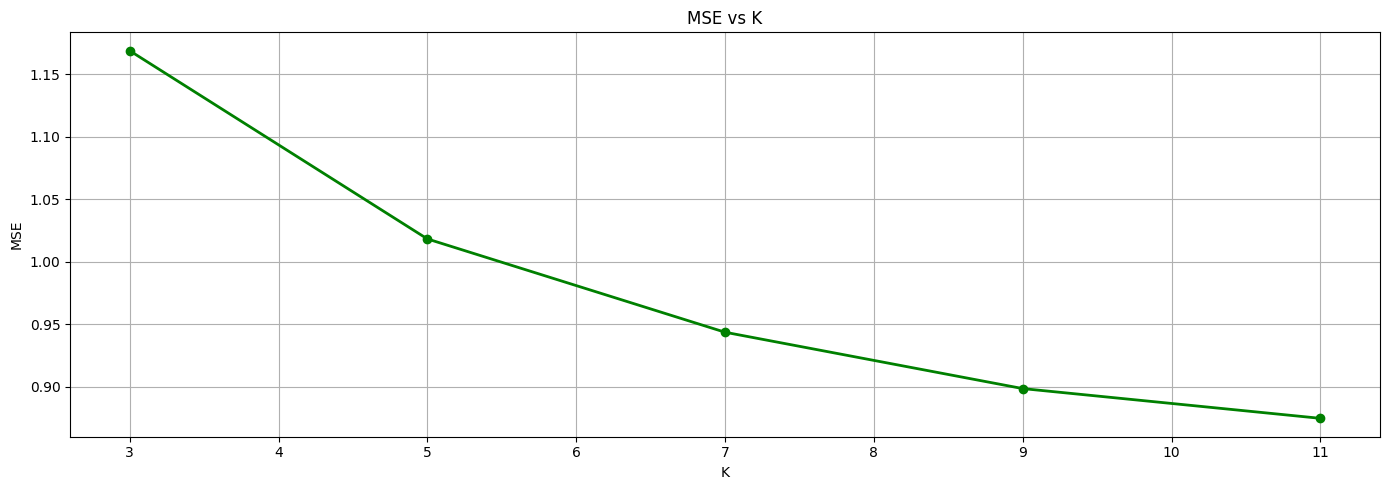

In [ ]:
# Trying several values of K over validation set
mse_list = []
K_list = [i for i in range(9, 19, 2)]   
for K in K_list:
    knn = KNN(k=K, metric="euclidean", weights="distance")
    knn.fit(X_train, y_train)
    mse = knn.get_mse(X_val, y_val)
    mse_list.append(mse)

plt.figure(figsize=(14, 5))
plt.plot(K_list, mse_list, color='green', marker='o', linewidth=2)
plt.xlabel("K")
plt.ylabel("MSE")
plt.title("MSE vs K")
plt.grid(True)
plt.tight_layout()
plt.show()